In [4]:
from pypfopt import risk_models,expected_returns,EfficientFrontier,plotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from src.utils.logger import logger
from src.utils.config import load_config
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation,get_latest_prices


class EfficientDiversification:
    def __init__(self,config):
        self.config = config
        self.all_prices = None #all assets combined
        self.mu = None # expected returns using pyportfolio
        self.S = None # Risk(Vol) through pyportfolio
        self.ef = None # Efficient Frontier using pyportfolio
        self.weights = None # weights
        self.perf = None #portfolio Performance
        
    def load_data(self):
        """Loads in data from yfinance using config.yaml"""
        self.all_prices = yf.download(tickers=self.config['all_tickers'],start=self.config['start_date'],end=self.config['end_date'])['Close']
        self.all_prices = self.all_prices.dropna()
        return self.all_prices   
    
    def eval_returns(self):
        """
        The pct change for each asset(returns). This is not the same
        as 'Expected Returns'
        """
        if self.all_prices is None:
            self.load_data()
            
     
        returns = self.all_prices.pct_change().dropna()
        logger.info(f'Returns from full portfolio: {returns.head()}')
        print(f'Returns: {returns}')
        return returns
    
    
    def portfolio_metrics(self):
        """
        (mu) -> Expected Returns (using pyportfolio)
        (S) -> Risk(Volatility);
        (Ef) -> Efficient Frontier;
        Most people(probably everyone honestly) wants to minimize risk in some way
        and Maximize some gain(this is everything in life)
        So, you want to maximize utility st. Budget Contraint; or
        Maximize returns given the risk st. the Weights......
        Or, Maximize Efficiency st limitations of hardware, ect.
        """
        if self.all_prices is None:
            self.load_data()
            if self.all_prices is None:
                return
            
        self.mu = expected_returns.mean_historical_return(self.all_prices)
        self.S = risk_models.sample_cov(self.all_prices)
        self.ef = EfficientFrontier(self.mu,self.S)
        logger.info("Portfolio Metrics(Expected Returns, S) has been calculated")
        
    def optimizing_portfolio(self,target_risk=None,target_return=None):
        """Optimizing Returns based on Efficient Frontier and Weights(there are four)"""
        if self.mu is None or self.S is None:
            self.portfolio_metrics()
            
        self.ef = EfficientFrontier(self.mu,self.S)
        
        if target_risk is not None:
            self.weights = self.ef.efficient_risk(target_risk)
            
        elif target_return is not None:
            self.weights = self.ef.efficient_return(target_return)
        
        else:
            self.weights = self.ef.max_sharpe() # default, this is what will be used more than likely.
            
        
        self.weights = self.ef.clean_weights()
        
        expected_annual_return, annual_volatility, sharpe_ratio = self.ef.portfolio_performance(verbose=True)


        
        self.perf = {
            "Expected Annual Return":expected_annual_return,
            "Annual Volatility":annual_volatility,
            "Sharpe Ratio":sharpe_ratio,
            
        }
        logger.info("Expected Annual Returns, Annual Volatiliy,and Sharpe Ratio")
        return self.weights,self.perf






In [5]:
config = load_config()
portfolio_optimizer = EfficientDiversification(config)
data = portfolio_optimizer.load_data()
data.head()


C:\Users\katsa\AppData\Local\Temp\ipykernel_5292\1107765997.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  self.all_prices = yf.download(tickers=self.config['all_tickers'],start=self.config['start_date'],end=self.config['end_date'])['Close']
[*********************100%***********************]  18 of 18 completed


Ticker,AAPL,ADA-USD,BND,BTC-USD,DAI-USD,GOOGL,IVV,MATIC-USD,META,MSFT,NVDA,QQQ,SOL-USD,SPY,TSLA,VTI,VUG,XPR-USD
Date,,,,,,,,,,,,,,,,,,
2020-10-12,121.143425,0.110034,76.614861,11555.363281,1.011544,77.763130,330.046143,0.017905,274.245483,212.632874,14.183506,286.001770,2.587072,329.467590,147.433334,167.960846,234.138824,0.010782
2020-10-13,117.929817,0.108852,76.675781,11425.899414,1.009135,77.886391,327.899933,0.017698,274.633392,214.035126,14.205688,285.992126,2.404910,327.317444,148.883331,167.074158,233.846985,0.010700
2020-10-14,118.017464,0.107297,76.719246,11429.506836,1.008179,77.705971,325.846893,0.017235,270.336945,212.114258,14.053145,283.603333,2.314635,325.260773,153.766663,165.963425,231.950241,0.010621
2020-10-15,117.550026,0.106635,76.675781,11495.349609,1.011332,77.309845,325.445679,0.017190,265.264771,210.961823,13.928270,281.700073,2.266436,324.858734,149.626663,166.019440,230.870560,0.010514
2020-10-16,115.904266,0.104064,76.614861,11322.123047,1.009288,77.917702,325.156403,0.016253,264.479034,210.961823,13.770245,280.156189,2.149386,324.662476,146.556671,165.720764,229.858887,0.010452


2025-07-18 14:48:27 - INFO - src.utils.logger - 39 - Returns from full portfolio: Ticker          AAPL   ADA-USD       BND   BTC-USD   DAI-USD     GOOGL  \
Date                                                                     
2020-10-13 -0.026527 -0.010742  0.000795 -0.011204 -0.002381  0.001585   
2020-10-14  0.000743 -0.014285  0.000567  0.000316 -0.000947 -0.002316   
2020-10-15 -0.003961 -0.006170 -0.000567  0.005761  0.003128 -0.005098   
2020-10-16 -0.014001 -0.024110 -0.000795 -0.015069 -0.002021  0.007863   
2020-10-19 -0.025542  0.044328 -0.000909  0.037088  0.002551 -0.024080   

Ticker           IVV  MATIC-USD      META      MSFT      NVDA       QQQ  \
Date                                                                      
2020-10-13 -0.006503  -0.011561  0.001414  0.006595  0.001564 -0.000034   
2020-10-14 -0.006261  -0.026161 -0.015644 -0.008975 -0.010738 -0.008353   
2020-10-15 -0.001231  -0.002611 -0.018762 -0.005433 -0.008886 -0.006711   
2020-10-16 -0.000889  -0

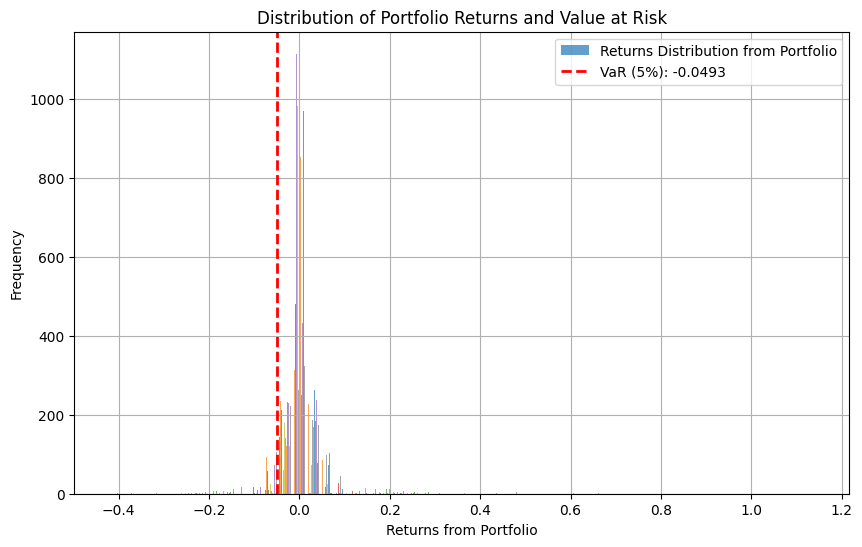

In [ ]:
returns = portfolio_optimizer.eval_returns()


"""VaR"""

def value_at_risk(returns, confidence_level=0.05):
    """Calculates Value at Risk (VaR)."""
    return np.quantile(returns, confidence_level)

VaR = value_at_risk(returns)

plt.figure(figsize=(10,6))
plt.hist(returns,bins=50,label="Returns Distribution from Portfolio",alpha=0.7)
plt.axvline(VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR (5%): {VaR:.4f}')
plt.title('Distribution of Portfolio Returns and Value at Risk')
plt.xlabel('Returns from Portfolio')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.savefig("images/VaR-EfficientDiversification.png")
plt.show()



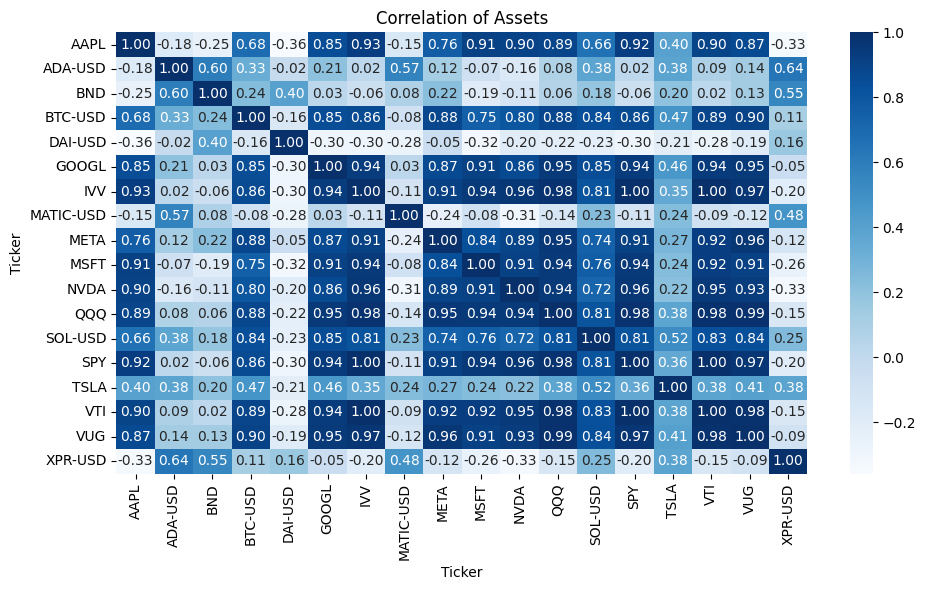

In [7]:
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(),fmt=".2f",annot=True,cmap="Blues")
plt.title("Correlation of Assets")
plt.tight_layout()
plt.savefig("images/ef_assets_heatmap.png")
plt.show()

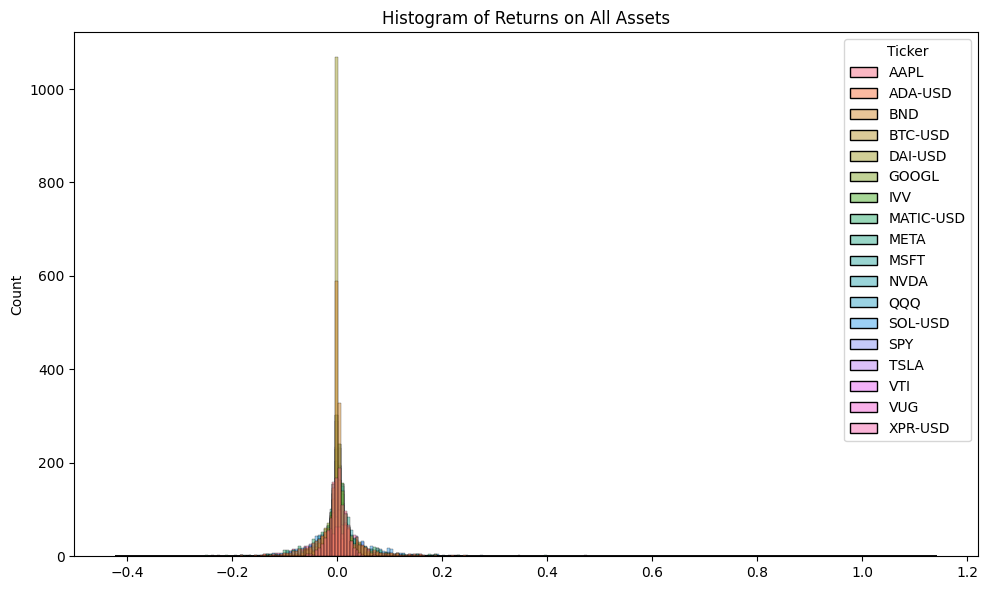

In [8]:
plt.figure(figsize=(10,6))
sns.histplot(returns,label="returns")
plt.title("Histogram of Returns on All Assets")
plt.tight_layout()
plt.savefig("images/histogram-returns.png")
plt.show()

In [9]:
portfolio_optimizer.portfolio_metrics()
optimizing = portfolio_optimizer.optimizing_portfolio()
optimizing

2025-07-18 14:48:46 - INFO - src.utils.logger - 63 - Portfolio Metrics(Expected Returns, S) has been calculated


Expected annual return: 84.4%
Annual volatility: 55.7%
Sharpe Ratio: 1.52
2025-07-18 14:48:46 - INFO - src.utils.logger - 94 - Expected Annual Returns, Annual Volatiliy,and Sharpe Ratio


(OrderedDict([('AAPL', 0.0),
              ('ADA-USD', 0.0),
              ('BND', 0.0),
              ('BTC-USD', 0.10778),
              ('DAI-USD', 0.0),
              ('GOOGL', 0.0),
              ('IVV', 0.0),
              ('MATIC-USD', 0.0),
              ('META', 0.0),
              ('MSFT', 0.0),
              ('NVDA', 0.62492),
              ('QQQ', 0.0),
              ('SOL-USD', 0.26729),
              ('SPY', 0.0),
              ('TSLA', 0.0),
              ('VTI', 0.0),
              ('VUG', 0.0),
              ('XPR-USD', 0.0)]),
 {'Expected Annual Return': np.float64(0.8442020106250911),
  'Annual Volatility': np.float64(0.5570209506731493),
  'Sharpe Ratio': np.float64(1.5155659937115273)})

In [10]:
weights = portfolio_optimizer.weights

print(f'Weights of Portfolio: {weights}')



Weights of Portfolio: OrderedDict([('AAPL', 0.0), ('ADA-USD', 0.0), ('BND', 0.0), ('BTC-USD', 0.10778), ('DAI-USD', 0.0), ('GOOGL', 0.0), ('IVV', 0.0), ('MATIC-USD', 0.0), ('META', 0.0), ('MSFT', 0.0), ('NVDA', 0.62492), ('QQQ', 0.0), ('SOL-USD', 0.26729), ('SPY', 0.0), ('TSLA', 0.0), ('VTI', 0.0), ('VUG', 0.0), ('XPR-USD', 0.0)])


In [11]:
"""Greedy Investor"""

latest_prices = get_latest_prices(data)
# Discrete Allocation is using the optimized weights and your Willingness to Pay to show you how much you would recieve st W* and WTP
da = DiscreteAllocation(weights, latest_prices,total_portfolio_value=1000000)
print(f'Latest Prices: {latest_prices}')
allocation, leftover = da.greedy_portfolio()
print(f'Allocation to Assets if you have $1000000 USD: {allocation}')
print(f'Leftover Cash if you were to spend $1000000 USD on optimized Weights: {leftover}')




Latest Prices: Ticker
AAPL           220.440918
ADA-USD          0.730995
BND             72.057922
BTC-USD      87498.914062
DAI-USD          1.000107
GOOGL          167.477249
IVV            574.924805
MATIC-USD        0.216415
META           618.374207
MSFT           392.359680
NVDA           121.401573
QQQ            490.109558
SOL-USD        140.869278
SPY            572.387878
TSLA           278.390015
VTI            282.163147
VUG            388.243042
XPR-USD          0.003978
Name: 2025-03-24 00:00:00, dtype: float64
Allocation to Assets if you have $1000000 USD: {'NVDA': 5147, 'SOL-USD': 1897, 'BTC-USD': 1}
Leftover Cash if you were to spend $1000000 USD on optimized Weights: 20418.168495178223


In [12]:
portfolio_optimizer.optimizing_portfolio()

Expected annual return: 84.4%
Annual volatility: 55.7%
Sharpe Ratio: 1.52
2025-07-18 14:49:01 - INFO - src.utils.logger - 94 - Expected Annual Returns, Annual Volatiliy,and Sharpe Ratio


(OrderedDict([('AAPL', 0.0),
              ('ADA-USD', 0.0),
              ('BND', 0.0),
              ('BTC-USD', 0.10778),
              ('DAI-USD', 0.0),
              ('GOOGL', 0.0),
              ('IVV', 0.0),
              ('MATIC-USD', 0.0),
              ('META', 0.0),
              ('MSFT', 0.0),
              ('NVDA', 0.62492),
              ('QQQ', 0.0),
              ('SOL-USD', 0.26729),
              ('SPY', 0.0),
              ('TSLA', 0.0),
              ('VTI', 0.0),
              ('VUG', 0.0),
              ('XPR-USD', 0.0)]),
 {'Expected Annual Return': np.float64(0.8442020106250911),
  'Annual Volatility': np.float64(0.5570209506731493),
  'Sharpe Ratio': np.float64(1.5155659937115273)})

In [13]:
weights,performace = portfolio_optimizer.optimizing_portfolio()
print(f'Weights from Portfolio: {weights}')
print(f'Performace of Portfolio: {performace}')

Expected annual return: 84.4%
Annual volatility: 55.7%
Sharpe Ratio: 1.52
2025-07-18 14:49:06 - INFO - src.utils.logger - 94 - Expected Annual Returns, Annual Volatiliy,and Sharpe Ratio
Weights from Portfolio: OrderedDict([('AAPL', 0.0), ('ADA-USD', 0.0), ('BND', 0.0), ('BTC-USD', 0.10778), ('DAI-USD', 0.0), ('GOOGL', 0.0), ('IVV', 0.0), ('MATIC-USD', 0.0), ('META', 0.0), ('MSFT', 0.0), ('NVDA', 0.62492), ('QQQ', 0.0), ('SOL-USD', 0.26729), ('SPY', 0.0), ('TSLA', 0.0), ('VTI', 0.0), ('VUG', 0.0), ('XPR-USD', 0.0)])
Performace of Portfolio: {'Expected Annual Return': np.float64(0.8442020106250911), 'Annual Volatility': np.float64(0.5570209506731493), 'Sharpe Ratio': np.float64(1.5155659937115273)}


C:\Users\katsa\AppData\Local\Temp\ipykernel_5292\3962976889.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


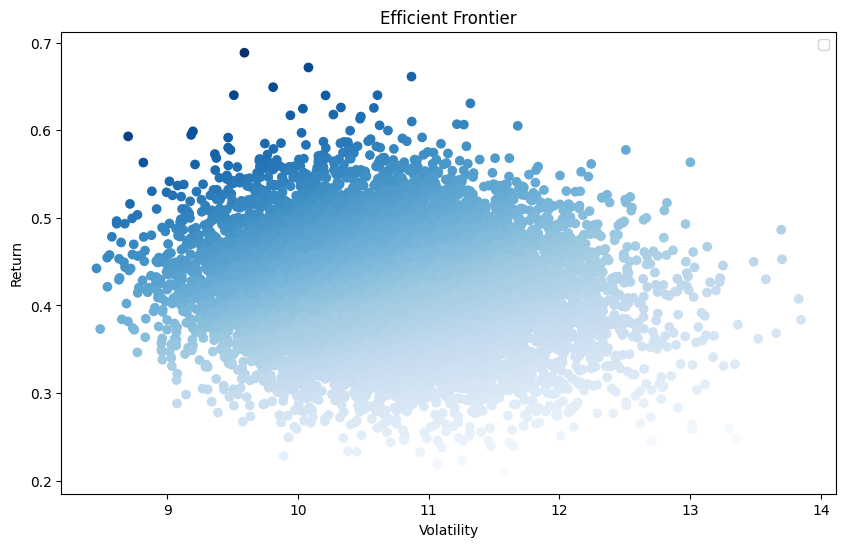

In [14]:
mean_returns = returns.mean()
num_portfolios = 10000
corr_matrix = data.corr()
results = np.zeros((3,num_portfolios))
for i in range(num_portfolios):
    weights = np.random.random(len(mean_returns))
    weights /= np.sum(weights)
  
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(corr_matrix, weights))) * np.sqrt(252)
      
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    results[2,i] = portfolio_return / portfolio_std_dev
  
results_df = pd.DataFrame(results.T,columns=['Return','Volatility','Sharpe'])

plt.figure(figsize=(10,6))
plt.scatter(results_df['Volatility'], results_df['Return'], c=results_df['Sharpe'], cmap='Blues')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.legend()
plt.savefig("images/bad_ef.png")
plt.show()